<a href="https://colab.research.google.com/github/mezkymy/ecommerce-ds/blob/dev/Final_Project_DS_Rakamin_Batch_31_Kelompok_4_(Cobra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run this to load file directly from kaggle (API key required)
# guide on how to use these commands: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
# no need to change anything in this cell, just load kaggle.json to files and run
# or just load Train.csv directly into files and skip this cell
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download prachi13/customer-analytics
# ! unzip customer-analytics.zip

In [29]:
# import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# # alternative to load file, uncomment to use
from google.colab import files
filenya = files.upload()

Saving Train.csv to Train.csv


In [2]:
# load csv file, create raw data (original copy) and dataframe (df) to manipulate
raw_data = pd.read_csv('Train.csv')
df = raw_data.copy()
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# 1. Data Exploration

Source: [E-Commerce Shipping Data from Kaggle](https://www.kaggle.com/datasets/prachi13/customer-analytics)

## Context (copied from Kaggle):
An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

## 1.1 Descriptive Statistics Analysis

In [ ]:
# check columns and null/non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


No null values detected on every columns

In [ ]:
# check if any ID is duplicated
df[df['ID'].duplicated()]

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N


<b>No duplicate ID detected.</b>

ID column can be dropped as it shall not be used in any further analysis.

In [3]:
# drop ID column
df.drop('ID', axis=1, inplace=True)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


In [ ]:
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Terdapat sebuah kejanggalan pada feature Discount_offered, dimana nilai maksimalnya sebesar 65 sedangkan selisih jaraknya dengan Q3 (10) atau mean (13) sangat tinggi, sehingga diduga terdapat beberapa outliers

In [ ]:
# categorical columns
categoricals = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

In [ ]:
df[categoricals].describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


Tidak terdapat kejanggalan pada Categorical Data karena setiap kolom memiliki jumlah data yang sama dengan jumlah total baris data dan tidak terdapat nilai yang tidak diharapkan seperti huruf atau karakter yang dianggap sebagai kejanggalan. 


## 1.2 Univariate Analysis


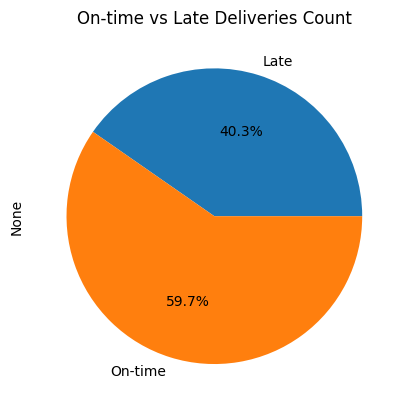

In [ ]:
# check ratio of on-time vs late deliveries
df.groupby('Reached.on.Time_Y.N').size().plot(kind='pie', labels=['Late', 'On-time'], autopct='%.1f%%')
plt.title('On-time vs Late Deliveries Count')
plt.show()

Diketahui bahwa proporsi pengiriman yang tepat waktu (On-time) sebesar 59,7% dan proporsi pengiriman yang terlambat (Late) sebesar 40,3%. Dapat disimpulkan bahwa sebagian besar pengiriman dilakukan tepat waktu, namun masih ada sebagian kecil pengiriman yang terlambat. Hal ini dapat menjadi fokus perbaikan untuk meningkatkan kualitas layanan dan kepuasan pelanggan.

Karena data sudah memiliki jumlah sampel yang cukup banyak dan tidak terlalu berbeda antara kelas satu dengan yang lain (tidak terlalu signifikan class imbalance-nya), maka tidak perlu dilakukan penyeimbangan lebih lanjut terhadap pada tahap pre-processing data.


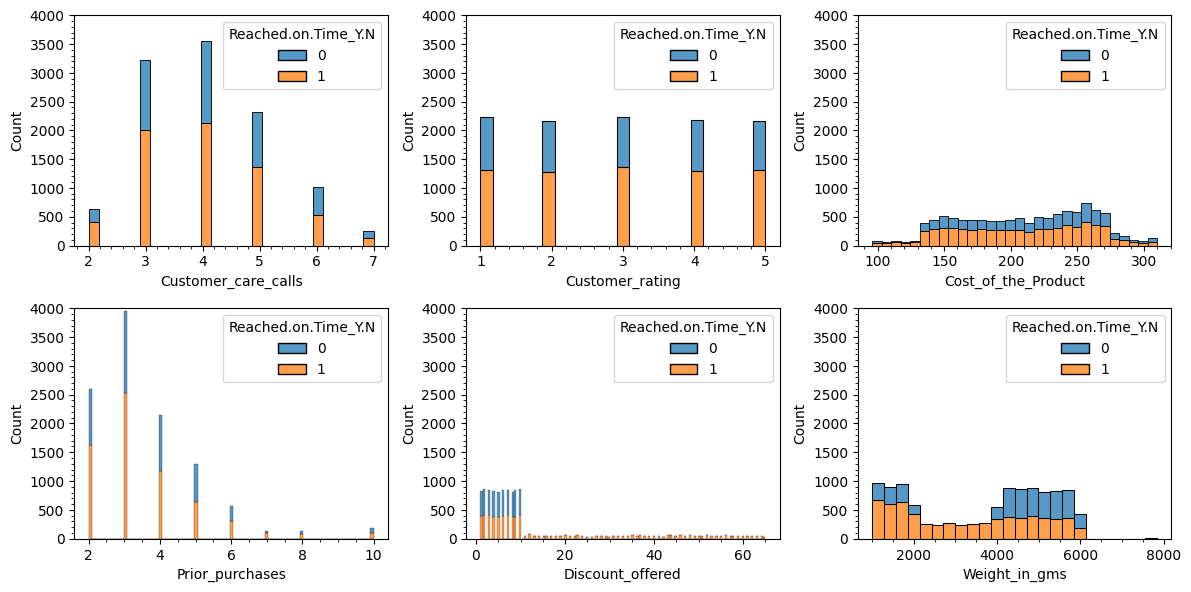

In [ ]:
# histogram for numeric columns
numeric_columns = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

# function to calculate bins based on Freedman-Diaconis (not used)
# def bins_fd(col):
#     n = col.count()
#     q1, q3 = col.quantile([0.25, 0.75])
#     range_tc = col.max() - col.min()
#     IQR = q3 - q1
#     return int(round(np.ceil(((n ** (1/3)) * range_tc)/(2 * IQR)), 0))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

i = 0
for y in axes:
    for ax in y:
        column = numeric_columns[i]
        sns.histplot(df, x=column, hue='Reached.on.Time_Y.N', multiple='stack', ax=ax)
        ax.minorticks_on()
        ax.set_ylim(0, 4000)
        i += 1

fig.tight_layout(pad=1)
plt.show()

Pada Feature Numeric terdapat beberapa hal yang menarik, diantaranya :
<!-- - Feature Prior_purchase membentuk positive skew
- Feature Weight_in_gms juga terdapat beberapa outlier pada nilai diatas 7500
- Feature Discount_offered terdapat nilai yang mendominasi yaitu pada nilai  0 - 10 -->

- Pada feature Prior_purchase membentuk positive skew
- Pada feature Weight_in_gms juga terdapat beberapa outlier pada nilai diatas 7500 (tidak terlalu terlihat pada grafik)
- Pada feature Discount_offered, terdapat nilai yang mendominasi yaitu pada nilai 0 - 10


Saat data pre-processing, perlu dilakukan scaling pada data numerik agar mempunyai range yang seragam.

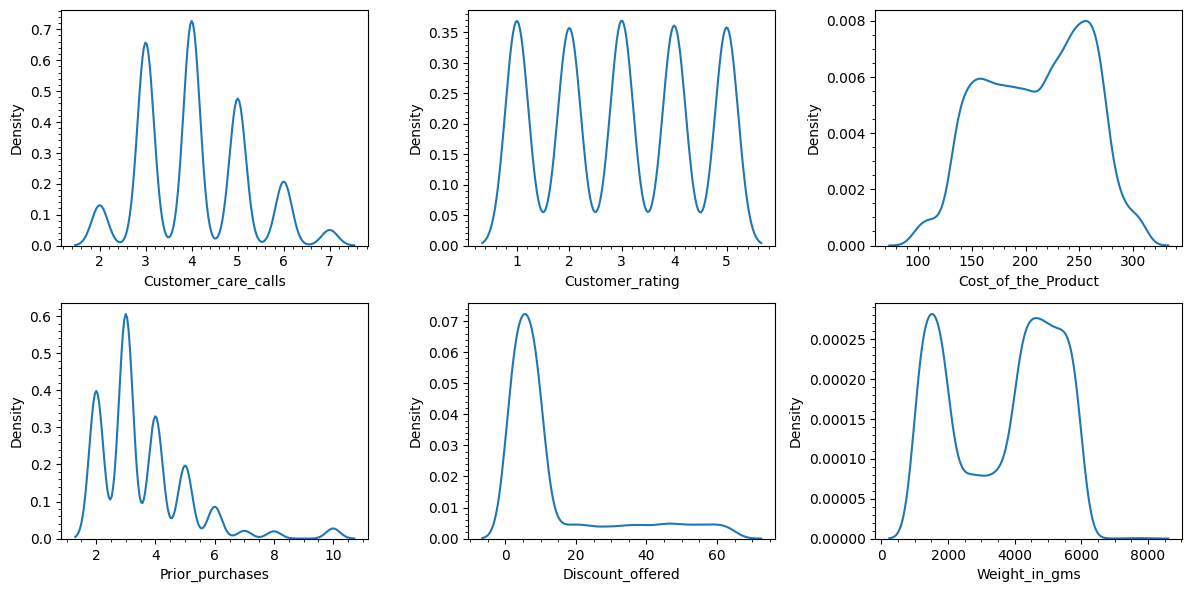

In [ ]:
# kdeplot for numeric columns (sebagai pembanding tampilan)
numeric_columns = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

i = 0
for y in axes:
    for ax in y:
        column = numeric_columns[i]
        sns.kdeplot(df, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

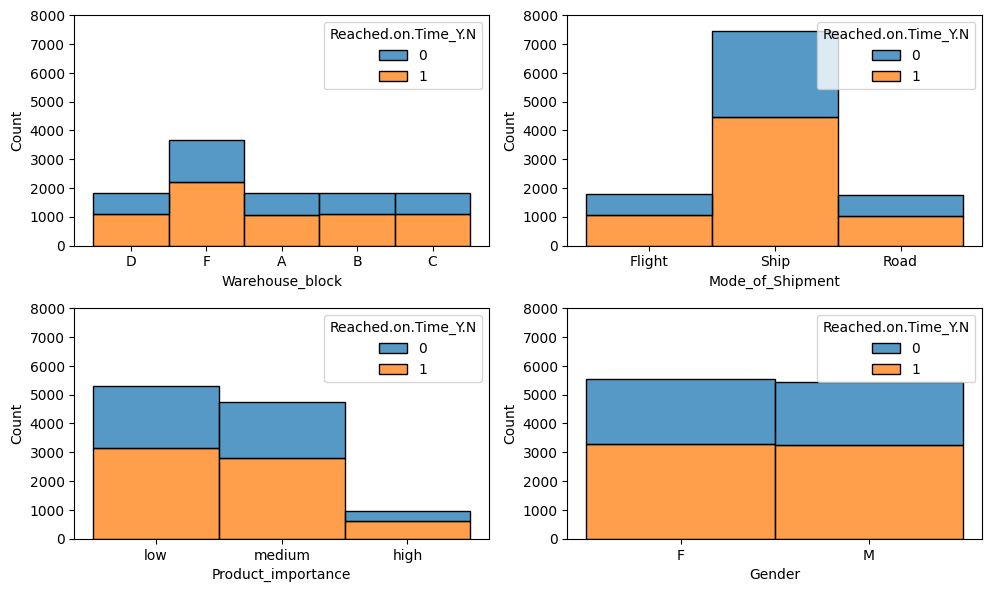

In [ ]:
# Create histplot for categorical columns
categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
i = 0

for y in axes:
    for ax in y:
        try:
            column = categorical_columns[i]
        except:
            break
        sns.histplot(df, x=column, hue='Reached.on.Time_Y.N', multiple='stack', ax=ax) 
        ax.set_ylim(0, 8000)
        i += 1

fig.tight_layout(pad=1)
plt.show()

<!-- ### Insights based on histograms
1. Distribution of `Customer_care_calls` and `Cost_of_the_product` are relatively normal, while the distribution of `Prior_purchases` and `Discount_offered` are positively skewed
2. Distribution of `Weight_in_gms` shows two peaks (bimodal), which might indicate an existance of two categories/segmentations

### Insights based on count plots
1. Warehouse `F` stores the most amount of items, while other warehouses stores  similar amount of items
2. Most items are shipped using the mode `Ship` (around ~70% of total shipments) -->

- Berdasarkan warehouse, barang paling banyak disimpan/dilayani oleh warehouse F, sedangkan warehouse lainnya kurang lebih menampung jumlah barang yang sama
- Mayoritas pengiriman dilakukan melalui jalur laut (Ship)
- Jumlah barang yang tingkat kepentingannya tinggi (high) relatif sedikit
- Jumlah customer pria hampir setara dengan jumlah customer wanita, dengan rasio keterlambatan yang juga serupa
- Beberapa hal yang harus ditindaklanjuti pada saat data pre-processing:
  - Untuk kolom Gender, dapat dilakukan mapping agar nilai "M" dan "F" menjadi 0 dan 1.
  - Untuk kolom Product_importance, dapat dilakukan label encoding karena kedua kolom tersebut memiliki nilai-nilai yang berurutan dan memiliki hubungan ordinal antara nilai-nilainya.
  - Untuk kolom Warehouse_block dan Mode_of_Shipment, dapat dilakukan one-hot encoding karena kolom tersebut tidak memiliki hubungan ordinal antara nilai-nilainya dan setiap nilai kategorikal dianggap sama pentingnya.




## 1.3 Multivariate Analysis

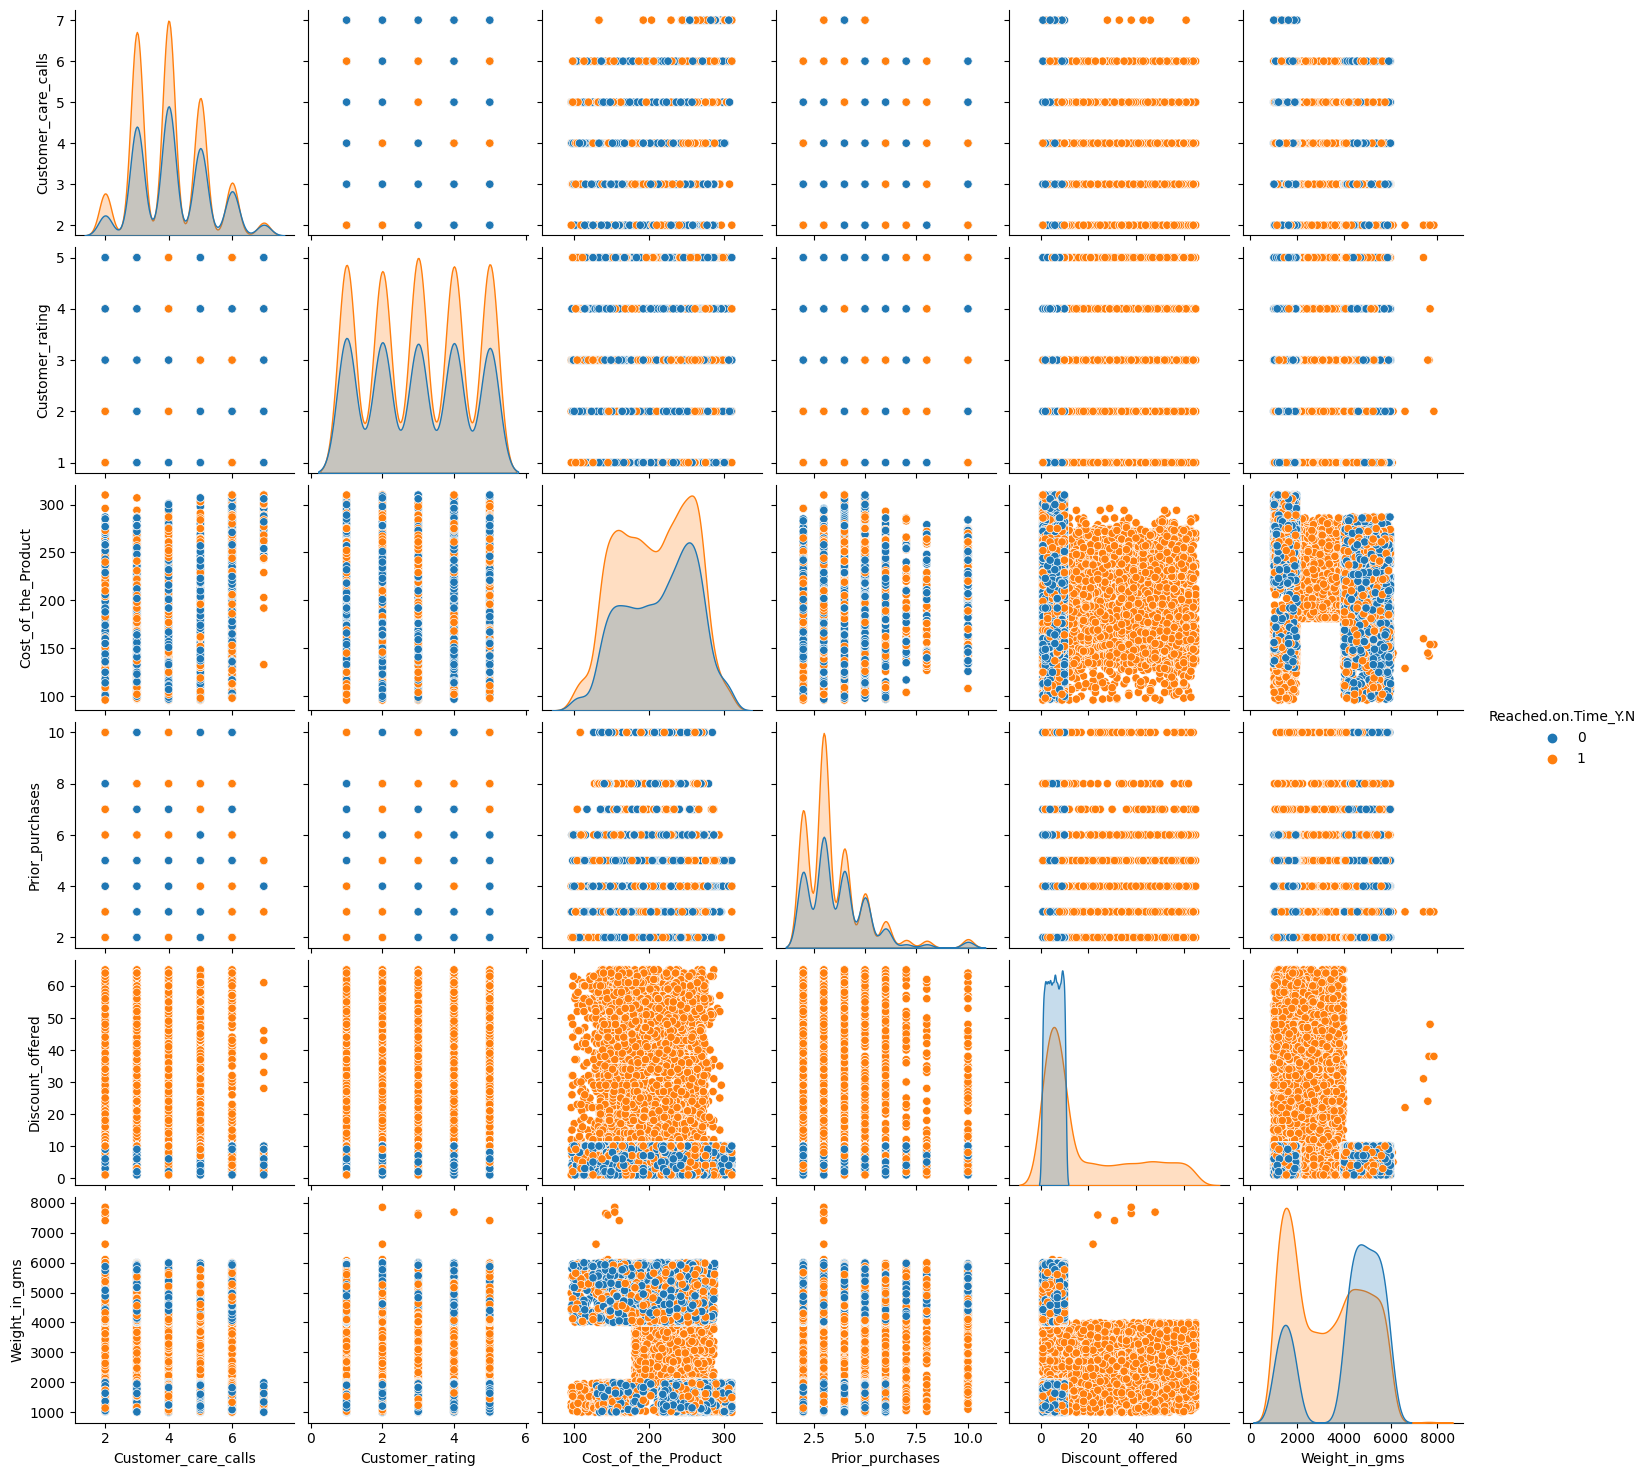

In [ ]:
# create pairplot for all numerical features
sns.pairplot(df, hue='Reached.on.Time_Y.N')
plt.show()

Terdapat segmentasi data yang secara visual cukup jelas terlihat pada beberapa pair plot. Secara visual, dapat diambil beberapa insight sebagai berikut:
- Pada discount offered terhadap weight, pada umumnya barang-barang yang beratnya di atas 4000 gram tidak diberikan diskon lebih besar dari 10% (kecuali untuk beberapa outlier).
- Tidak ditemukan barang terlambat pada barang yang diberikan diskon lebih dari 10%
- Barang dengan berat di antara 2000-4000 gram harganya ada di kisaran ~200 sampai ~300 dollar, dan tidak ada yang terlambat pengirimannya
- Terdapat beberapa data outlier jika dilihat berdasarkan berat barang (Weight_in_gms), yaitu barang-barang yang beratnya melebihi 6000 gram, namun untuk barang-barang tersebut tidak ada satupun yang mengalami keterlambatan
- Berdasarkan hasil korelasi antara feature, terdapat beberapa hal yang perlu dilakukan, yaitu:
  - Beberapa data outlier pada berat barang (Weight_in_gms) yang perlu diobservasi lebih lanjut untuk memastikan apakah data tersebut valid atau tidak. Jika data tersebut valid, maka dapat dipertimbangkan untuk menggunakan teknik pre-processing seperti pengurangan dimensi (PCA) atau penanganan outlier untuk memperbaiki performa model.


### Insight Customer Care Calls
Semakin tinggi persentase keterlambatan pengiriman, semakin banyak jumlah customer care calls yang diterima oleh perusahaan.

Hal tersebut menunjukkan bahwa keterlambatan pengiriman dapat mempengaruhi kepuasan pelanggan, sehingga pelanggan perlu menghubungi customer care untuk mendapatkan informasi lebih lanjut mengenai status pengiriman.


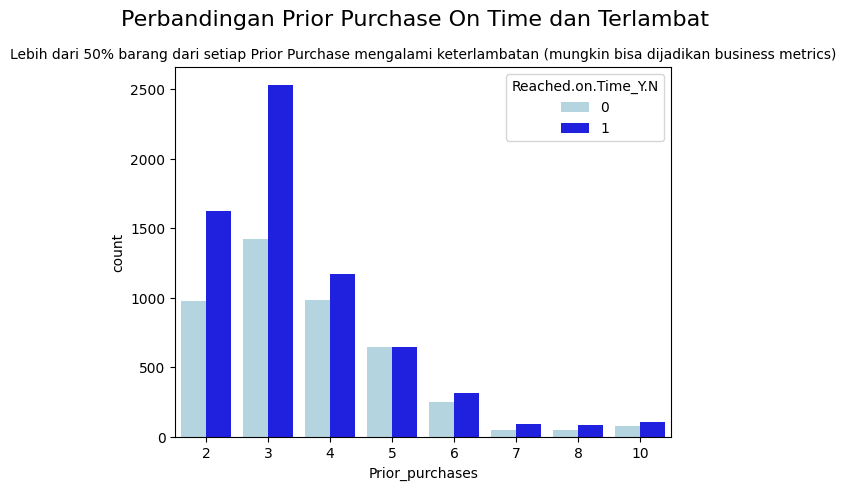

In [ ]:
# menambahkan grafik (MUFID)
ax = sns.countplot(x=df['Prior_purchases'], hue=df['Reached.on.Time_Y.N'], palette={0: 'lightblue', 1: 'blue'})
total = len(df['Prior_purchases'])

# for p in ax.patches:
#     percentage = '{:.1f}%'.format(100 * p.get_height()/total)
#     x = p.get_x() + p.get_width() / 2 - 0.05
#     y = p.get_y() + p.get_height() + 10
#     ax.annotate(percentage, (x, y), size = 7)

plt.suptitle('Perbandingan Prior Purchase On Time dan Terlambat', y=1, fontsize=16)
plt.title('Lebih dari 50% barang dari setiap Prior Purchase mengalami keterlambatan (mungkin bisa dijadikan business metrics)', fontsize=10)

plt.show()

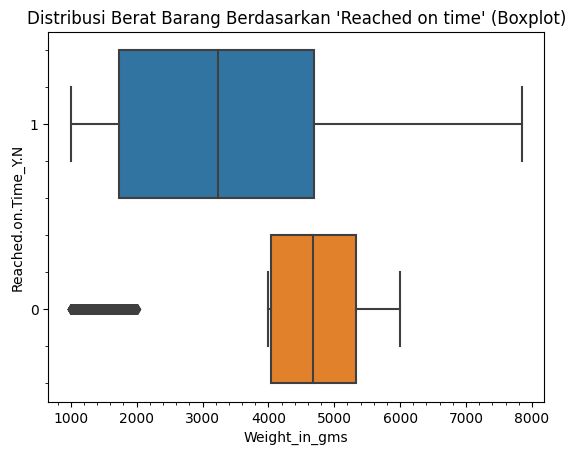

In [ ]:
sns.boxplot(data=df.astype({'Reached.on.Time_Y.N':'string'}), x="Weight_in_gms", y="Reached.on.Time_Y.N").set(title="Distribusi Berat Barang Berdasarkan 'Reached on time' (Boxplot)")

plt.minorticks_on()
plt.show()

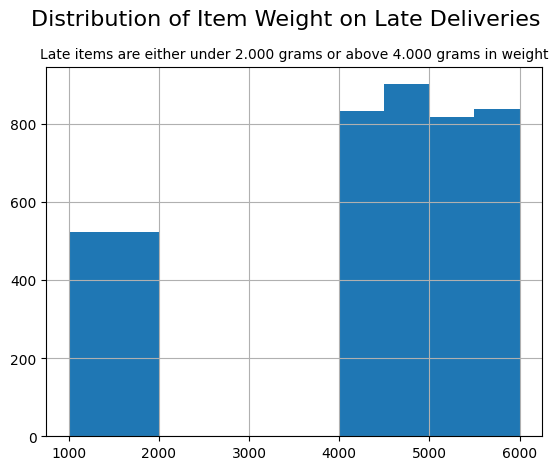

In [ ]:
df[df['Reached.on.Time_Y.N'] == 0].hist(column = "Weight_in_gms")
plt.suptitle('Distribution of Item Weight on Late Deliveries', y=1, fontsize=16)
plt.title('Late items are either under 2.000 grams or above 4.000 grams in weight', fontsize=10)
plt.show()

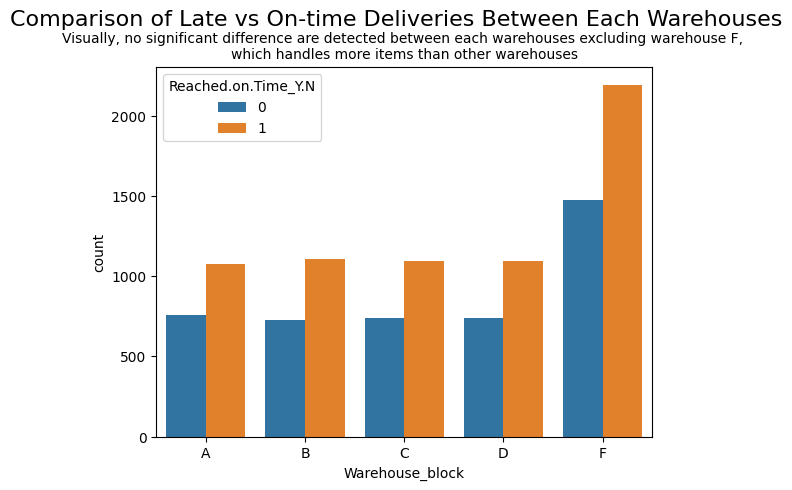

In [ ]:
sns.countplot(data=df, x="Warehouse_block", order=['A', 'B', 'C', 'D', 'F'], hue="Reached.on.Time_Y.N")
plt.suptitle('Comparison of Late vs On-time Deliveries Between Each Warehouses', y=1, fontsize=16)
plt.title(f'Visually, no significant difference are detected between each warehouses excluding warehouse F, \nwhich handles more items than other warehouses', fontsize=10)
plt.show()

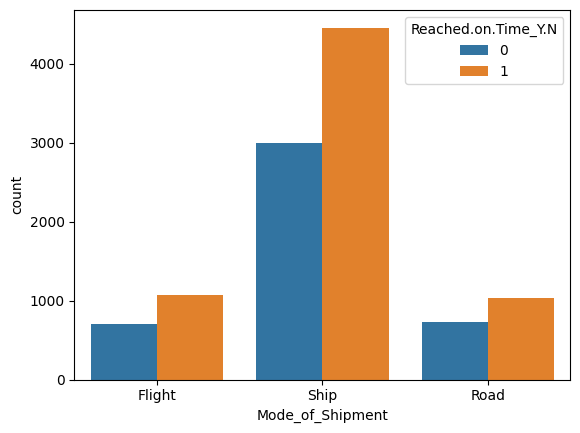

In [ ]:
sns.countplot(data=df, x="Mode_of_Shipment", hue="Reached.on.Time_Y.N")
plt.show()

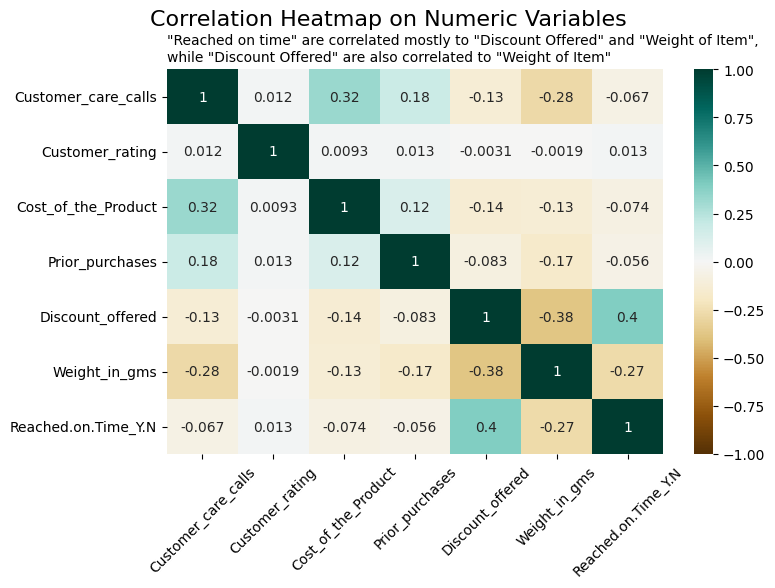

In [ ]:
# correlation heatmap with pearson
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='BrBG', vmin=-1, vmax=1, fmt='.2g')
plt.xticks(rotation = 45)
plt.suptitle('Correlation Heatmap on Numeric Variables', horizontalalignment='right', x=0.7, y=1, fontsize=16)
plt.title(f'"Reached on time" are correlated mostly to "Discount Offered" and "Weight of Item", \nwhile "Discount Offered" are also correlated to "Weight of Item"', loc='left', fontsize=10)

plt.show()

<!-- - Discount_offered dengan Reached.on.Time_Y.N berkorelasi sedang positif, sedangkan Weight_in_gms dengan Reached.on.Time_Y.N berkorelasi lemah negatif
- Discount_offered dengan Weight_in_gms berkorelasi sedang negatif (diduga dapat mengakibatkan multikolinearitas)
- Cost_of_the_Product dengan Customer_care_calls berkorelasi sedang positif -->

Berdasarkan hasil heatmap yang dibuat korelasi antar feature beragam dengan range 1 sampai -1. Semakin mendekati 1 atau -1 maka korelasi semakin kuat, sedangkan semakin mendekati 0 maka korelasi semakin lemah. Beberapa nilai korelasi yang paling relevan adalah sebagai berikut:

- Discount_offered dengan Reached.on.Time_Y.N berkorelasi sedang positif, sedangkan Weight_in_gms dengan Reached.on.Time_Y.N berkorelasi lemah negatif
- Discount_offered dengan Weight_in_gms berkorelasi sedang negatif (diduga dapat mengakibatkan multikolinearitas)
- Cost_of_the_Product dengan Customer_care_calls berkorelasi sedang positif
Customer_rating memiliki korelasi yang sangat kecil terhadap seluruh fitur lainnya, termasuk keterlambatan pengiriman

- Berdasarkan hasil korelasi antara feature, terdapat beberapa hal yang perlu dilakukan, yaitu:

  - Discount_offered dan Weight_in_gms memiliki korelasi yang cukup signifikan, sehingga perlu dilakukan pengecekan terhadap adanya multikolinearitas antara kedua feature tersebut. Jika ditemukan adanya multikolinearitas, salah satu feature dapat dihapus atau digabungkan dengan feature lain.

  - Korelasi antara Cost_of_the_Product dengan Customer_care_calls perlu diperhatikan pada saat modelling. Jika terdapat multikolinearitas, feature yang memiliki korelasi lebih rendah dengan target (Reached.on.Time_Y.N) dapat dihapus atau digabungkan dengan feature lain.

  - Feature yang memiliki korelasi rendah dengan target (Reached.on.Time_Y.N) namun memiliki korelasi yang tinggi dengan feature lain juga perlu diperhatikan pada saat modelling. Pada beberapa kasus, feature tersebut mungkin dapat dihapus atau digabungkan dengan feature lain untuk menghindari multikolinearitas dan meningkatkan akurasi model.



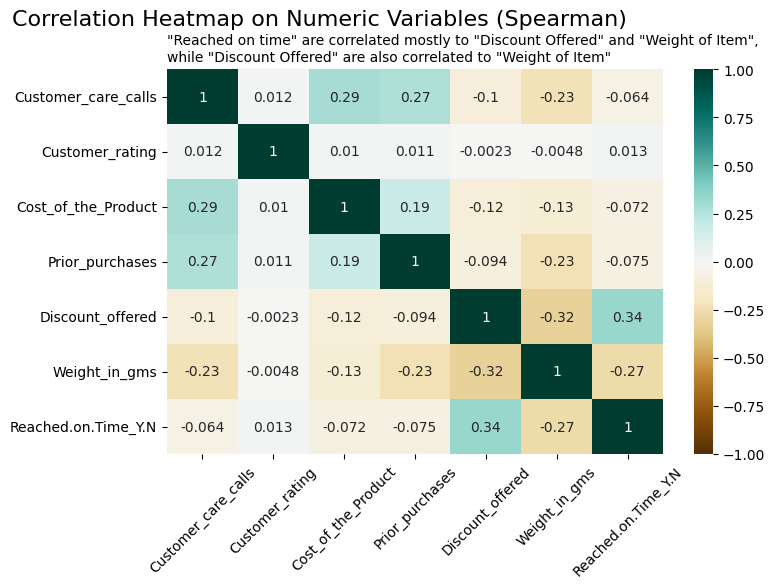

In [ ]:
# correlation with spearman
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, cmap='BrBG', vmin=-1, vmax=1, fmt='.2g')
plt.xticks(rotation = 45)
plt.suptitle('Correlation Heatmap on Numeric Variables (Spearman)', horizontalalignment='right', x=0.7, y=1, fontsize=16)
plt.title(f'"Reached on time" are correlated mostly to "Discount Offered" and "Weight of Item", \nwhile "Discount Offered" are also correlated to "Weight of Item"', loc='left', fontsize=10)

plt.show()

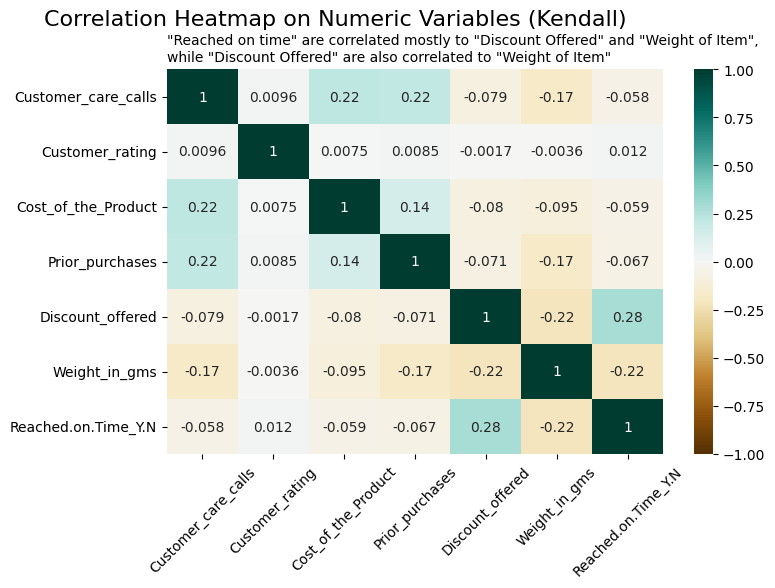

In [ ]:
# correlation with kendall
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df.corr(method='kendall', numeric_only=True), annot=True, cmap='BrBG', vmin=-1, vmax=1, fmt='.2g')
plt.xticks(rotation = 45)
plt.suptitle('Correlation Heatmap on Numeric Variables (Kendall)', horizontalalignment='right', x=0.7, y=1, fontsize=16)
plt.title(f'"Reached on time" are correlated mostly to "Discount Offered" and "Weight of Item", \nwhile "Discount Offered" are also correlated to "Weight of Item"', loc='left', fontsize=10)

plt.show()

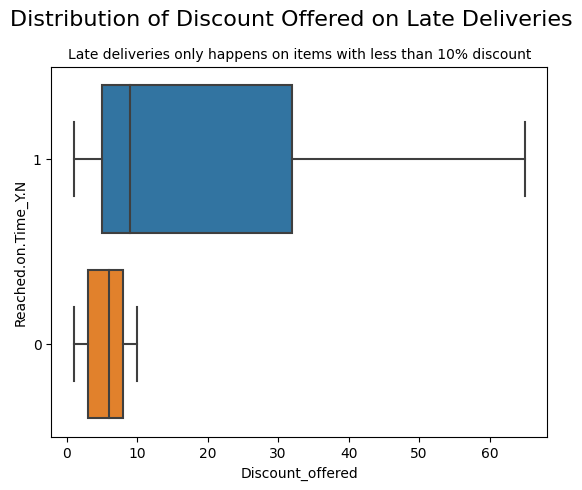

In [ ]:
sns.boxplot(data=df.astype({'Reached.on.Time_Y.N':'string'}), x="Discount_offered", y='Reached.on.Time_Y.N')
plt.suptitle('Distribution of Discount Offered on Late Deliveries', y=1, fontsize=16)
plt.title('Late deliveries only happens on items with less than 10% discount', fontsize=10)
plt.show()

In [ ]:
# coba - coba
df.groupby('Mode_of_Shipment').agg({'Weight_in_gms' : 'mean'})

,Weight_in_gms
Mode_of_Shipment,
Flight,3629.378165
Road,3649.550568
Ship,3631.457518


<Axes: xlabel='Weight_in_gms', ylabel='Mode_of_Shipment'>

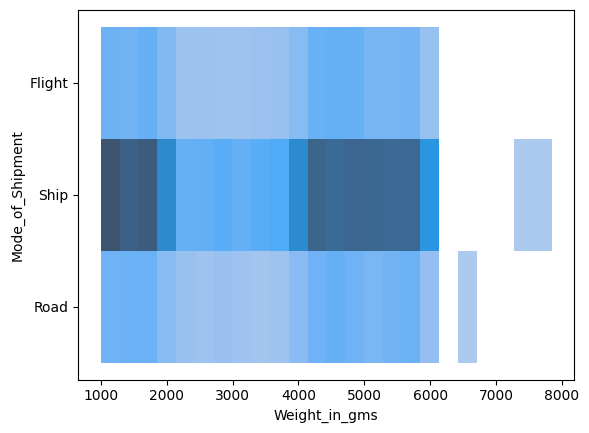

In [ ]:
# coba - coba
sns.histplot(x='Weight_in_gms', y='Mode_of_Shipment', data=df)

<Axes: xlabel='Weight_in_gms', ylabel='Mode_of_Shipment'>

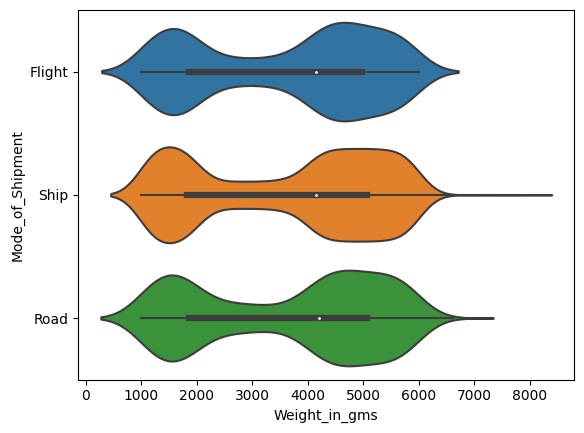

In [ ]:
# coba ganti grafik ya mbak (MUFID)
sns.violinplot(x='Weight_in_gms', y='Mode_of_Shipment', data=df)

Text(1.5, 0, 'Distribusi pengiriman barang yang\ntidak merata di ketiga armada,\ndimana 67.84% pengiriman menggunakan kapal')

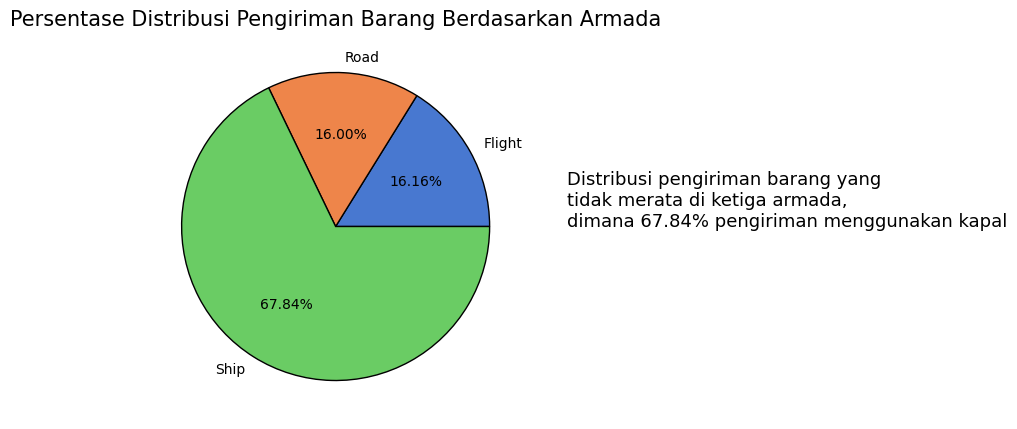

In [ ]:
# Filtering Kolom
# Kode perlu di refactor karena ID sudah di drop #done
total = df.groupby('Mode_of_Shipment').agg({'Weight_in_gms' : 'count'}).reset_index()
total['rasio'] = round(total['Weight_in_gms']*100/10999, 2)

# Visualisasi Data
plt.figure(figsize=(10,5))
plt.pie(total['rasio'], labels=total['Mode_of_Shipment'], colors=sns.color_palette('muted'),
          wedgeprops={'edgecolor':'k'}, autopct='%.2f%%')

# Judul
plt.title('Persentase Distribusi Pengiriman Barang Berdasarkan Armada', fontsize=15)

# Keterangan
plt.text(x=1.5, y=0, s='Distribusi pengiriman barang yang\ntidak merata di ketiga armada,\ndimana 67.84% pengiriman menggunakan kapal', fontsize=13)

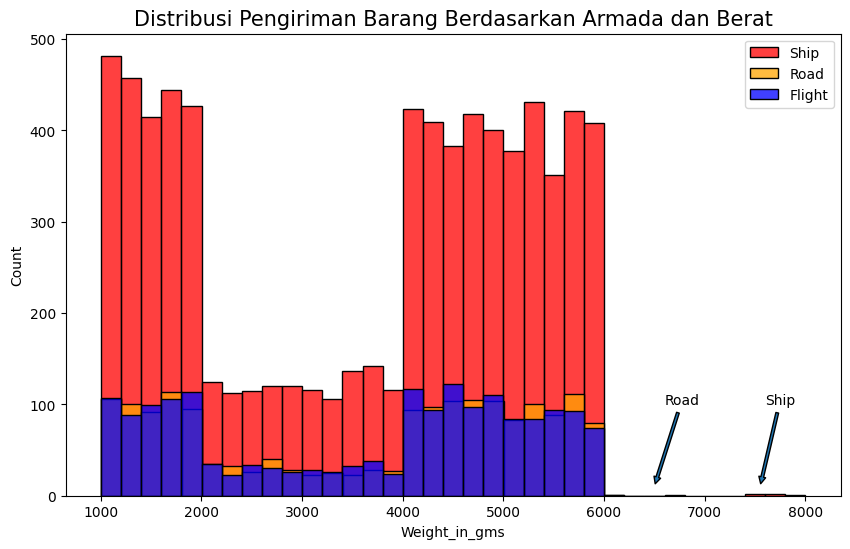

In [ ]:
#Filtering Kolom
flight = df[df['Mode_of_Shipment']=='Flight']
ship = df[df['Mode_of_Shipment']=='Ship']
road = df[df['Mode_of_Shipment']=='Road']

#Visualisasi Distribusi Barang
plt.figure(figsize=(10,6))
sns.histplot(x='Weight_in_gms', binwidth=200, color='red', data=ship, label='Ship')
sns.histplot(x='Weight_in_gms', binwidth=200, color='orange', data=road, label='Road')
sns.histplot(x='Weight_in_gms', binwidth=200, color='blue', data=flight, label='Flight')

#Judul
plt.title('Distribusi Pengiriman Barang Berdasarkan Armada dan Berat', fontsize=15)

#Keterangan Tambahan
plt.annotate('Road',
            xy=(6500,10), xytext=(6600, 100), arrowprops=dict(ec='black', arrowstyle='simple',))
plt.annotate('Ship',
            xy=(7550,10), xytext=(7600, 100), arrowprops=dict(ec='black', arrowstyle='simple',))

#Legenda
plt.legend(loc=1)

plt.show()

<Axes: xlabel='Mode_of_Shipment', ylabel='Weight_in_gms'>

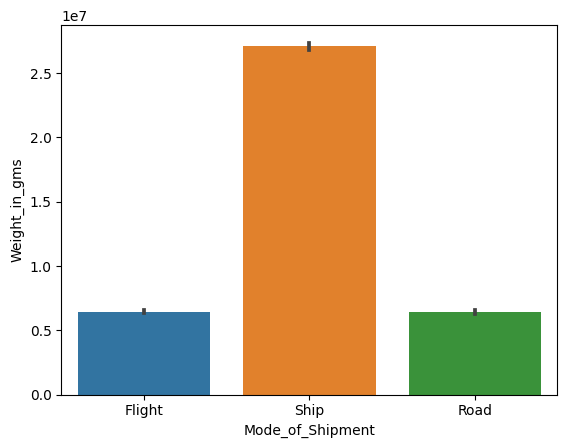

In [ ]:
# coba - coba
sns.barplot(x='Mode_of_Shipment', y='Weight_in_gms', estimator=sum, data=df)

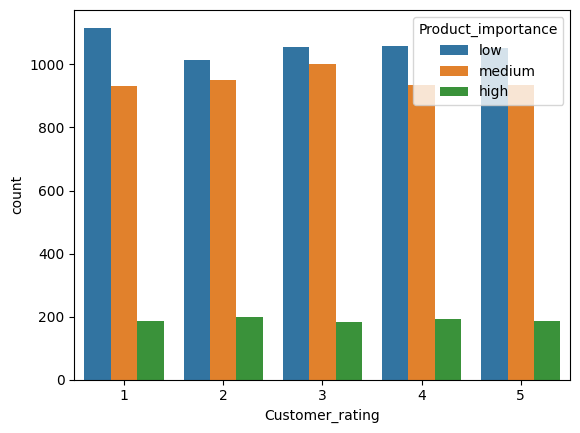

In [ ]:
sns.countplot(data=df, x="Customer_rating", hue="Product_importance")
plt.show()

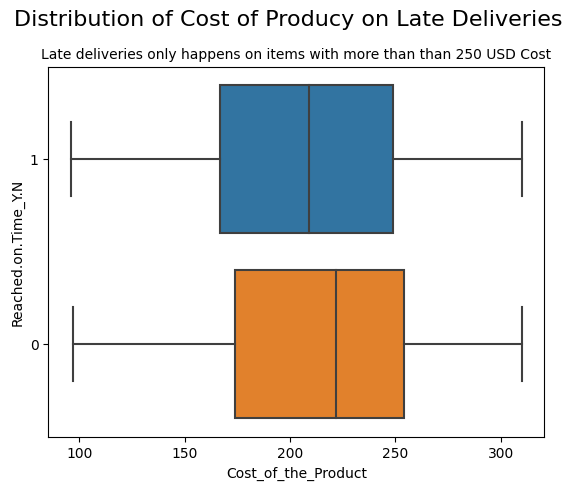

In [ ]:
sns.boxplot(data=df.astype({'Reached.on.Time_Y.N':'string'}), x="Cost_of_the_Product", y='Reached.on.Time_Y.N')
plt.suptitle('Distribution of Cost of Producy on Late Deliveries', y=1, fontsize=16)
plt.title('Late deliveries only happens on items with more than than 250 USD Cost', fontsize=10)
plt.show()

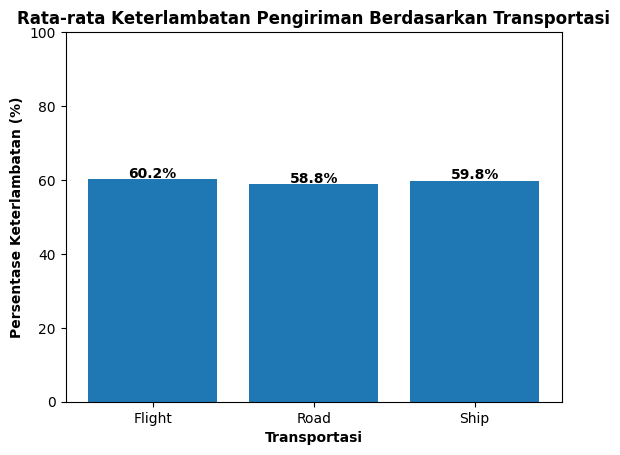

In [ ]:
# Calculate late delivery percentage for each mode of transport
delay_by_shipment = df.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean() * 100

# Membuat bar plot
plt.bar(delay_by_shipment.index, delay_by_shipment.values)

# Menambahkan label untuk setiap bar
for i, v in enumerate(delay_by_shipment.values):
    plt.text(i, v+0.5, str(round(v,1)) + '%', ha='center', fontweight='bold')

# Menambahkan label pada sumbu x dan y, serta judul grafik
plt.title('Rata-rata Keterlambatan Pengiriman Berdasarkan Transportasi', fontweight='bold')
plt.xlabel('Transportasi', fontweight='bold')
plt.ylabel('Persentase Keterlambatan (%)', fontweight='bold')
plt.ylim(0, 100)

# Menampilkan grafik
plt.show()

### Insight:

Pengiriman melalui penerbangan memiliki tingkat keterlambatan pengiriman yang lebih tinggi dibandingkan pengiriman melalui kapal atau jalan darat.


### Rekomendasi Bisnis:

Evaluasi ulang pengiriman melalui penerbangan, pertimbangkan opsi pengiriman alternatif seperti kapal atau jalan darat, atau tingkatkan kualitas layanan pengiriman melalui penerbangan.

In [ ]:
# Mencari hubungan antara Mode of shipment, warehouse block & Dicount offered (MUFID)

df_br = df.groupby(['Mode_of_Shipment', 'Warehouse_block']).agg({'Weight_in_gms' : ['mean'],'Discount_offered': ['mean', 'sum'],'Reached.on.Time_Y.N':'sum'}).reset_index()
df_br

Mode_of_Shipment Warehouse_block Weight_in_gms Discount_offered         \
                                             mean             mean    sum   
0            Flight               A   3660.171717        13.050505   3876   
1            Flight               B   3601.966216        12.584459   3725   
2            Flight               C   3625.569492        12.725424   3754   
3            Flight               D   3672.316498        13.208754   3923   
4            Flight               F   3607.991554        13.697635   8109   
5              Road               A   3602.901361        13.163265   3870   
6              Road               B   3615.602041        13.037415   3833   
7              Road               C   3661.574830        13.748299   4042   
8              Road               D   3677.500000        12.496575   3649   
9              Road               F   3670.027304        13.027304   7634   
10             Ship               A   3607.724638        13.277778  16491   
11             Ship               B   3648.488335        13.366050  16614   
12             Ship               C   3640.284566        13.477492  16766   
13             Ship               D   3607.065863        13.206426  16442   
14             Ship               F   3642.588424        13.811897  34364   

   Reached.on.Time_Y.N  
                   sum  
0                  174  
1                  177  
2                  184  
3                  178  
4                  356  
5                  168  
6                  172  
7                  169  
8                  174  
9                  352  
10                 733  
11                 755  
12                 741  
13                 744  
14                1486

# 2. Data Pre-Processing

In [13]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler 

## 2.1 Data Cleansing

In [6]:
# split data into features & target
target = 'Reached.on.Time_Y.N'
features = df.loc[:, df.columns != target].columns
x_data = df[features]
y_data = df[target]

In [68]:
# split data menjadi 80% data train dan 20% data test

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=25)

# check amount of data on train and test
print('banyaknya data train =', x_train.shape[0])
print('banyaknya data test =', x_test.shape[0])

# check if split is balanced based on target value
print('mean value of y on train =', y_train.mean())
print('mean value of y on test =', y_test.mean())

banyaknya data train = 8799
banyaknya data test = 2200
mean value of y on train = 0.5962041141038754
mean value of y on test = 0.5986363636363636


### 2.1.1 Handle missing values, duplicated data, dan outliers

Dari Bagian 1.1 (<i>Descriptive Statistics Analytics</i>), diketahui bahwa data <b>tidak memiliki missing value maupun data duplikat</b>. 

In [ ]:
# memeriksa outlier dari tiap kolom numerik menggunakan zscore test
cats = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

zscore = pd.DataFrame()
outlier = pd.DataFrame()

for col in nums:
    zscore[col] = abs(stats.zscore(x_train[col])) # hitung absolute z-scorenya
    outlier[col] = x_train[col][zscore[col]>3]

outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 7687 to 9125
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  0 non-null      float64
 1   Customer_rating      0 non-null      float64
 2   Cost_of_the_Product  0 non-null      float64
 3   Prior_purchases      146 non-null    int64  
 4   Discount_offered     1 non-null      float64
 5   Weight_in_gms        0 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 8.0 KB


Berdasarkan uji, nilai zscore > 3 dianggap sebagai outlier. Kolom yang memiliki outlier adalah `Prior_purchases` dan `Discount_offered`. 

In [ ]:
# memeriksa outlier dari tiap kolom numerik menggunakan IQR
cats = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

outlier_iqr = pd.DataFrame()

for col in nums:
    Q1 = x_train[col].quantile(0.25)
    Q3 = x_train[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)
    outlier_iqr[col] = x_train[col][(df[col] < low_limit) | (df[col] > high_limit)]

outlier_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814 entries, 2779 to 6618
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  0 non-null      float64
 1   Customer_rating      0 non-null      float64
 2   Cost_of_the_Product  0 non-null      float64
 3   Prior_purchases      814 non-null    int64  
 4   Discount_offered     144 non-null    float64
 5   Weight_in_gms        0 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 44.5 KB


Outliers on `Prior_purchases` and `Discount_offered` based on IQR are less than 10% of the total train data. (just remove outliers?)

### 2.1.2 Feature Transformation

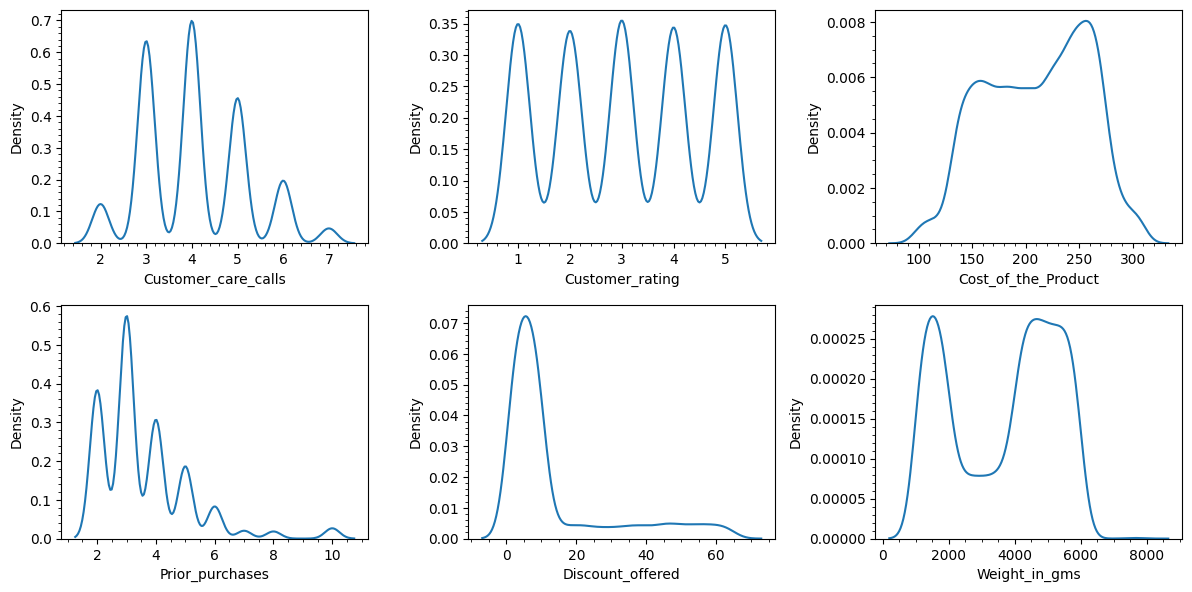

In [70]:
# Tinjau distribusi dari kolom-kolom numerik pada data menggunakan kdeplot dari data yang telah di smoothing

nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

i = 0
for y in axes:
    for ax in y:
        column = nums[i]
        sns.kdeplot(x_train, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

Kolom Customer_care_calls, Customer_rating, Cost_of_the_Product, dan Weight_in_gms sudah memiliki distribusi yang normal. Sedangkan Prior_purchases dan Discount_offered belum. Perhatikan bahwa data pada setiap kolom memiliki skala yang berbeda. Sehingga transformasi yang akan diterapkan adalah normalization untuk kolom Prior_purchases dan Discount_offer, lalu MinMaxScaler untuk semua feature.

In [64]:
col = ['Prior_purchases', 'Discount_offered']
x_train_transform = x_train
x_train_transform[col] = Normalizer().fit_transform(x_train[col].values.reshape(len(x_train),2))
x_train_transform[nums] = MinMaxScaler().fit_transform(x_train[nums].values.reshape(x_train[nums].shape))

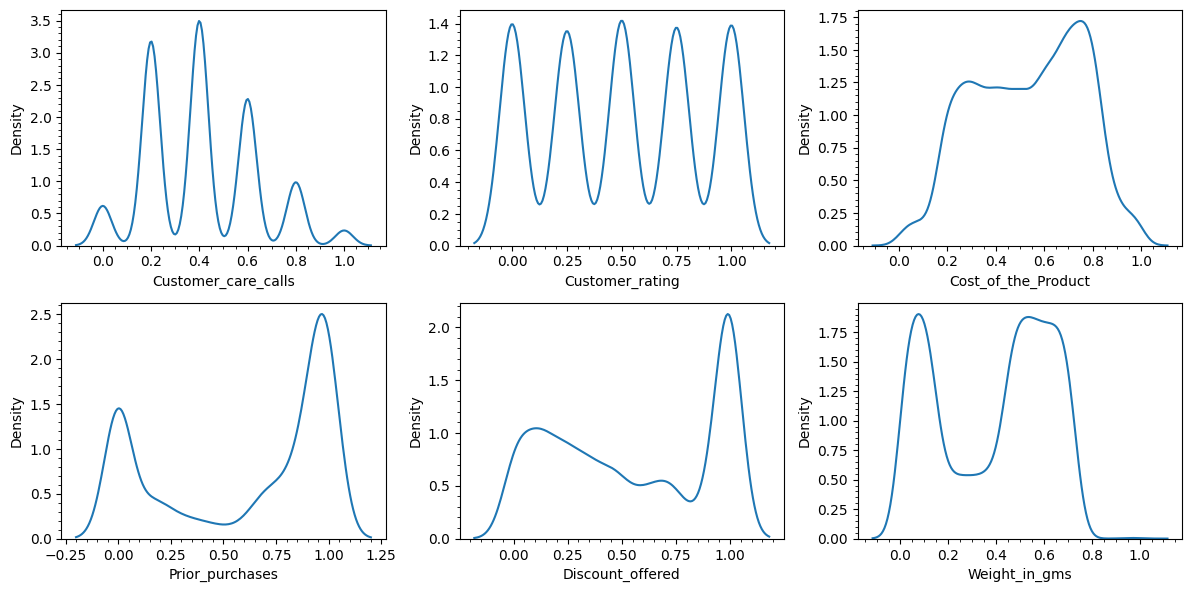

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

i = 0
for y in axes:
    for ax in y:
        column = nums[i]
        sns.kdeplot(x_train_transform, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

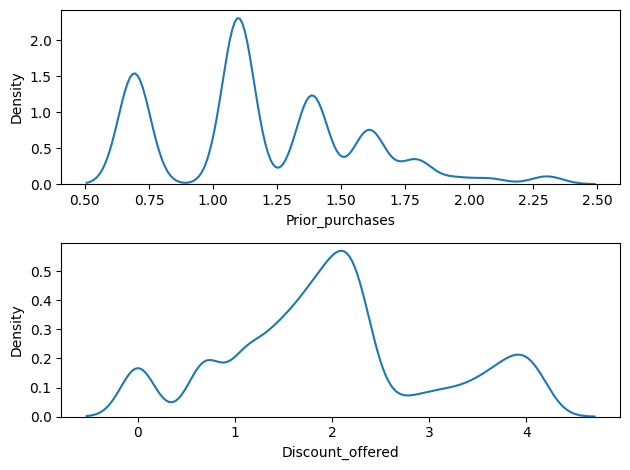

In [71]:
# Opsi lain adalah menggunakan log transformation
plt.subplot(2, 1, 1)
y1 = x_train['Prior_purchases']
sns.kdeplot(np.log(y1))

plt.subplot(2, 1, 2) 
y2 = x_train['Discount_offered']
sns.kdeplot(np.log(y2))

plt.tight_layout()
plt.show()

### 2.1.3 Feature Encoding

In [ ]:
# OHE = 'Warehouse_block', 'Mode_of_Shipment'
# Binary = 'Gender'
# Ordinal/Label = 'Product_importance'


### 2.1.4 Handle Class Imbalance

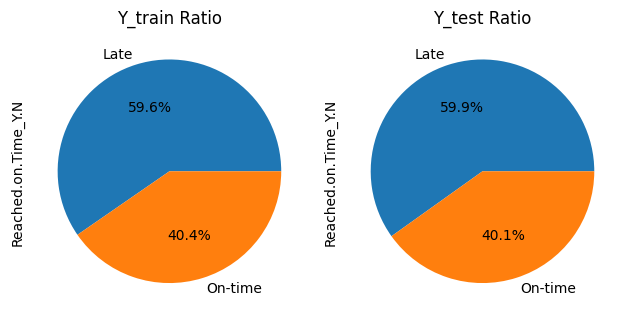

In [ ]:
# check ratio on on-time vs late deliveries
plt.subplot(1, 2, 1)
plt.title('Y_train Ratio')
y_train.value_counts().plot.pie(labels=['Late', 'On-time'], autopct='%.1f%%')
plt.subplot(1, 2, 2)
plt.title('Y_test Ratio')
y_test.value_counts().plot.pie(labels=['Late', 'On-time'], autopct='%.1f%%')

plt.tight_layout(pad=1)
plt.show()

Based on the ratio of late vs on-time deliveries on both train and test data, the imbalance is negligible and treatment to the class imbalance is <b>not necessary</b>.

## 2.2 Feature Engineering

### 2.2.1 Feature Selection

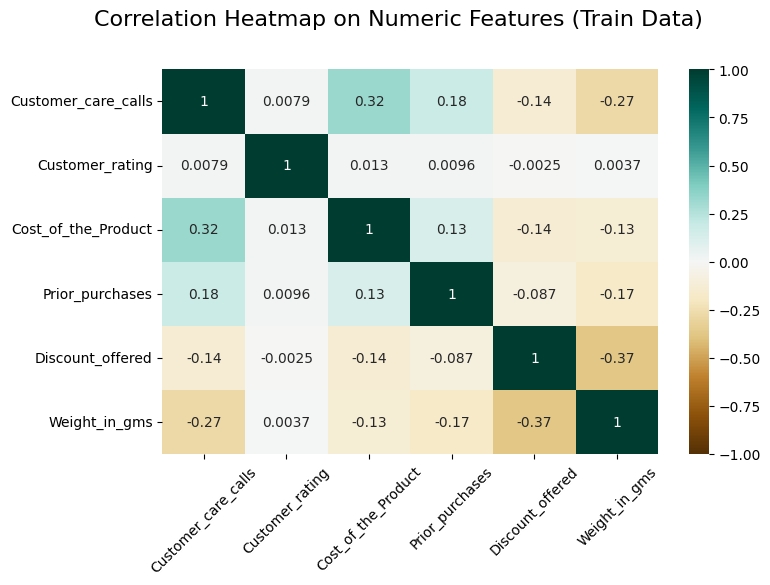

In [ ]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(x_train.corr(numeric_only=True), annot=True, cmap='BrBG', vmin=-1, vmax=1, fmt='.2g')
plt.xticks(rotation = 45)
plt.suptitle('Correlation Heatmap on Numeric Features (Train Data)', horizontalalignment='right', x=0.8, y=1, fontsize=16)

plt.show()

Based on the correlation heatmap of features on train data, it is indicated that `Weight_in_gms` have a small-medium correlation to `Discount_offered` and `Customer_care_calls`, while `Customer_care_calls` also have a correlation with `Cost_of_the_product`. 

Using correlated features may introduce multicolinearity.

`Customer_rating` are not related to any of the features, and are also not related with the target itself (can be seen in EDA). Thus, it can be concluded that it is safe to remove this feature completely from the model.

In [ ]:
# using ANOVA?

### 2.2.2 Feature Extraction